#Student Name: Abhinav Kaushal Keshari
#ECE 595 Intro To DL
#Project 3: GAN - Student Code

In [1]:
#Import necessary packages
import numpy as np
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras.models import load_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


#Part 1: Implementing the GAN

Epoch 10000
10000: [Discriminaotr loss: 0.641572, acc: 0.425781]  [GAN loss: 0.951829, acc: 0.250000]


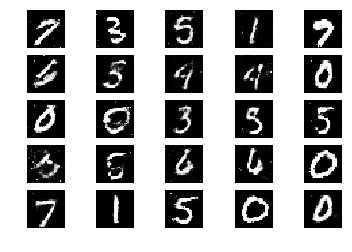

Epoch 20000
20000: [Discriminaotr loss: 0.644069, acc: 0.320312]  [GAN loss: 1.282968, acc: 0.132812]


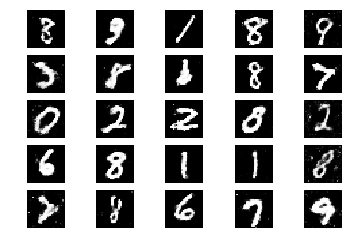

Epoch 30000
30000: [Discriminaotr loss: 0.533847, acc: 0.421875]  [GAN loss: 1.814959, acc: 0.046875]


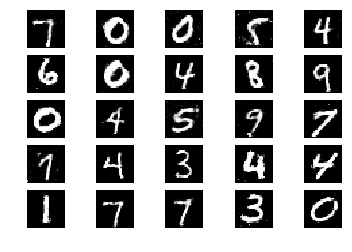

Epoch 40000
40000: [Discriminaotr loss: 0.496109, acc: 0.464844]  [GAN loss: 1.474779, acc: 0.140625]


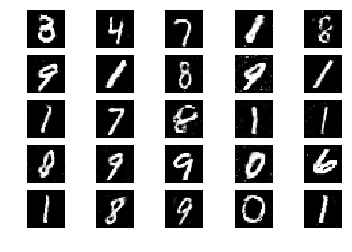

Epoch 50000
50000: [Discriminaotr loss: 0.440825, acc: 0.445312]  [GAN loss: 1.944968, acc: 0.015625]


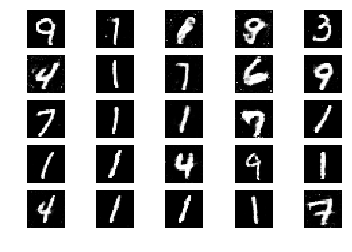

Epoch 60000
60000: [Discriminaotr loss: 0.418684, acc: 0.449219]  [GAN loss: 2.450243, acc: 0.015625]


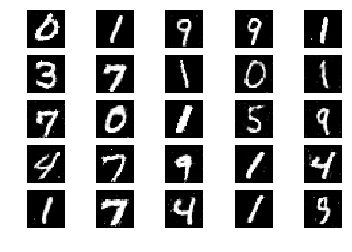

Epoch 70000
70000: [Discriminaotr loss: 0.433956, acc: 0.476562]  [GAN loss: 2.044839, acc: 0.039062]


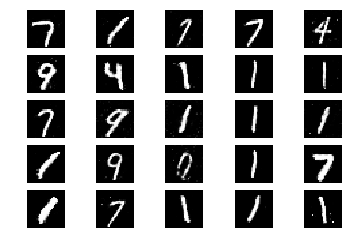

Epoch 80000
80000: [Discriminaotr loss: 0.371694, acc: 0.480469]  [GAN loss: 2.557491, acc: 0.007812]


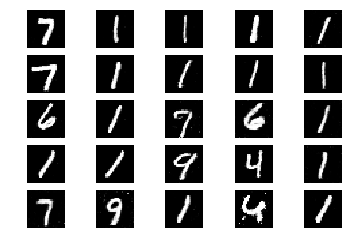

Epoch 90000
90000: [Discriminaotr loss: 0.324606, acc: 0.492188]  [GAN loss: 2.720458, acc: 0.031250]


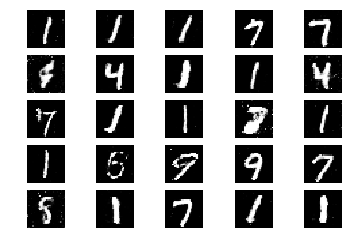

Epoch 100000
100000: [Discriminaotr loss: 0.332741, acc: 0.492188]  [GAN loss: 2.551484, acc: 0.023438]


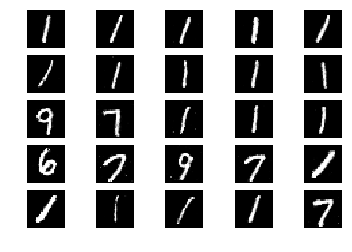

In [ ]:
#Load MNIST data and normalize to [-1, 1]
(data_train, labels_train), (data_test, labels_test)= mnist.load_data()
data_train = data_train.reshape(-1, 784)
mean = data_train.mean()
data_train = (data_train - 127.5)/127.5

# The D-dimensional noise vector length
latent_dim = 100

# data_dim
data_dim = 784

# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def adam_optimizer(learning_rate, beta_1, beta_2):
    return adam(learning_rate=learning_rate, beta_1=beta_1, beta_2 = beta_2)

# Genrerator model
def create_generator():
    generator = Sequential()
    generator.add(Dense(300, input_dim=latent_dim))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(600))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(1200))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(data_dim, activation='tanh'))
    return generator

# Discriminator model
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(1200, input_dim=data_dim))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dense(600))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dense(300))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=adam_optimizer(0.0002, 0.5, 0.999),
                          metrics=['accuracy'])
    return discriminator

# Create adversarial model
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy',
                optimizer=adam_optimizer(0.001, 0.5, 0.999),
                metrics=['accuracy'])
    return gan

# Creating GAN
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

# Model and training parameters
#ASSIGN VALUES TO THE FOLLOWING VARIABLES
epochs = 100000
batch_size = 128
sample_interval = 10000

# Array to save training history
training_meta_data = np.zeros([epochs, 4])

# Training the GAN
for e in range(1, epochs+1):
    # Generate random noise as input
    random_noise = np.random.normal(0, 1, size=[batch_size, latent_dim])

    # Generate fake MNIST images from generated noise
    fake_images = generator.predict(random_noise)

    # Get a random set of real MNIST images
    real_images = np.array([data_train[np.random.randint(len(data_train))] for i in range(batch_size)])

    # Concatenate real and fake images into a single array (or batch)
    data_total = np.concatenate((fake_images, real_images))

    # Assign training labels (assign high probability, but not 1, to real images)
    labels_fake = np.zeros(batch_size)
    labels_real = np.array([0.9 for i in range(batch_size)])
    labels_total = np.concatenate((labels_fake, labels_real))

    # Allow discriminator parameters to be updated
    discriminator.trainable = True

    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    d_loss = discriminator.train_on_batch(data_total, labels_total)

    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    random_noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    labels_generator = np.ones(batch_size)

    # Keep discriminator weights constant while training generator
    discriminator.trainable = False

    # Train GAN (without updating discriminator weights) on new batch of fake images. Assign loss and accuracy to variable
    gan_loss = gan.train_on_batch(random_noise, labels_generator)

    # Save training status
    # Discriminator and model loss
    training_meta_data[e-1, 0] = d_loss[0]
    training_meta_data[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data[e-1, 2] = d_loss[1]
    training_meta_data[e-1, 3] = gan_loss[1]


    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
        print("Epoch %d" %e)
        log_mesg = "%d: [Discriminaotr loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator.predict(random_noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

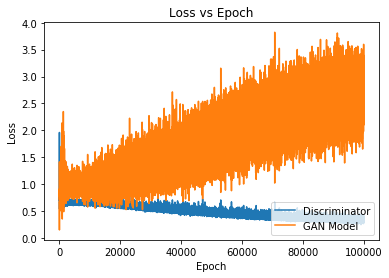

In [ ]:
 # Plot model loss vs epoch
plt.title('Loss vs Epoch')
plt.plot(training_meta_data[:,0]) #Plot the discriminator loss
plt.plot(training_meta_data[:,1]) #Plot the gan loss
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'GAN Model'], loc='lower right')
plt.show()

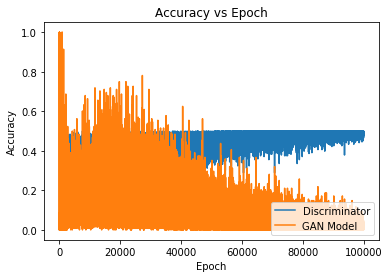

In [ ]:
# Plot accuracy vs epoch
plt.title('Accuracy vs Epoch')
plt.plot(training_meta_data[:,2]) #Plot the discriminator accuracy
plt.plot(training_meta_data[:,3]) #Plot the gan accuracy
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'GAN Model'], loc='lower right')
plt.show()

Epoch 10000
10000: [Discriminaotr loss: 0.695971, acc: 0.382812]  [GAN loss: 0.891508, acc: 0.093750]


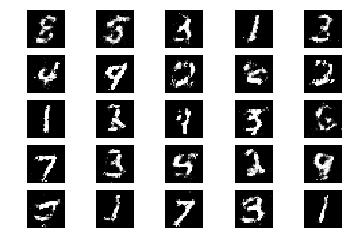

Epoch 20000
20000: [Discriminaotr loss: 0.678122, acc: 0.402344]  [GAN loss: 0.888387, acc: 0.140625]


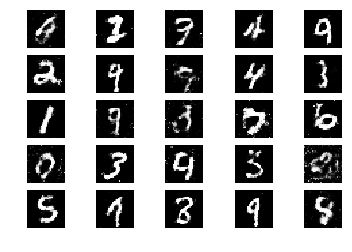

Epoch 30000
30000: [Discriminaotr loss: 0.646137, acc: 0.445312]  [GAN loss: 0.908375, acc: 0.148438]


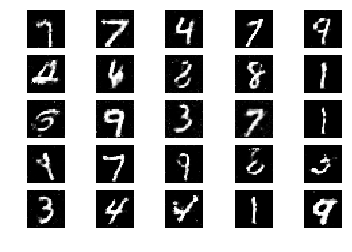

Epoch 40000
40000: [Discriminaotr loss: 0.653491, acc: 0.410156]  [GAN loss: 0.985335, acc: 0.171875]


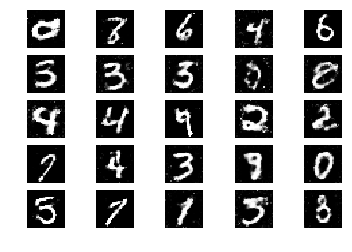

Epoch 50000
50000: [Discriminaotr loss: 0.650772, acc: 0.371094]  [GAN loss: 0.923550, acc: 0.234375]


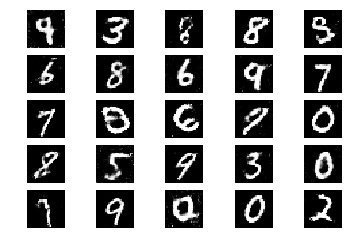

Epoch 60000
60000: [Discriminaotr loss: 0.616863, acc: 0.417969]  [GAN loss: 1.043963, acc: 0.218750]


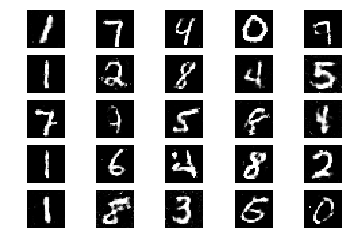

Epoch 70000
70000: [Discriminaotr loss: 0.638178, acc: 0.414062]  [GAN loss: 1.057854, acc: 0.156250]


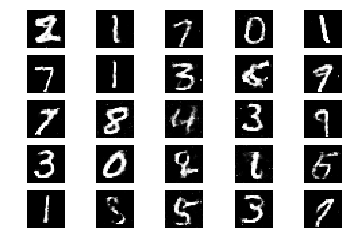

Epoch 80000
80000: [Discriminaotr loss: 0.613979, acc: 0.386719]  [GAN loss: 1.051564, acc: 0.156250]


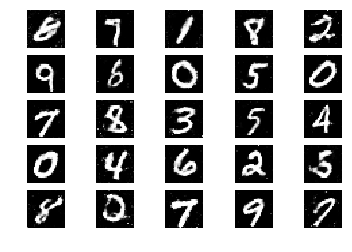

Epoch 90000
90000: [Discriminaotr loss: 0.590026, acc: 0.417969]  [GAN loss: 1.244974, acc: 0.085938]


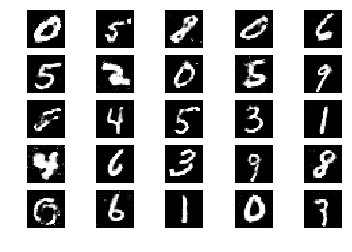

Epoch 100000
100000: [Discriminaotr loss: 0.599335, acc: 0.437500]  [GAN loss: 1.094933, acc: 0.195312]


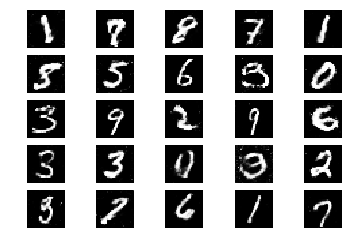

In [ ]:
#Load MNIST data and normalize to [-1, 1]
(data_train, labels_train), (data_test, labels_test)= mnist.load_data()
data_train = data_train.reshape(-1, 784)
mean = data_train.mean()
data_train = (data_train - 127.5)/127.5

# The D-dimensional noise vector length
latent_dim = 100

# data_dim
data_dim = 784

# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def adam_optimizer(learning_rate, beta_1, beta_2):
    return adam(learning_rate=learning_rate, beta_1=beta_1, beta_2 = beta_2)

# Genrerator model
def create_generator():
    generator = Sequential()
    generator.add(Dense(300, input_dim=latent_dim))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(600))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(1200))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(data_dim, activation='tanh'))
    return generator

# Discriminator model
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(1200, input_dim=data_dim))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.33))
    discriminator.add(Dense(600))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.33))
    discriminator.add(Dense(300))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.33))
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=adam_optimizer(0.0002, 0.5, 0.999),
                          metrics=['accuracy'])
    return discriminator

# Create adversarial model
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy',
                optimizer=adam_optimizer(0.001, 0.5, 0.999),
                metrics=['accuracy'])
    return gan

# Creating GAN
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

# Model and training parameters
#ASSIGN VALUES TO THE FOLLOWING VARIABLES
epochs = 100000
batch_size = 128
sample_interval = 10000

# Array to save training history
training_meta_data = np.zeros([epochs, 4])

# Training the GAN
for e in range(1, epochs+1):
    # Generate random noise as input
    random_noise = np.random.normal(0, 1, size=[batch_size, latent_dim])

    # Generate fake MNIST images from generated noise
    fake_images = generator.predict(random_noise)

    # Get a random set of real MNIST images
    real_images = np.array([data_train[np.random.randint(len(data_train))] for i in range(batch_size)])

    # Concatenate real and fake images into a single array (or batch)
    data_total = np.concatenate((fake_images, real_images))

    # Assign training labels (assign high probability, but not 1, to real images)
    labels_fake = np.zeros(batch_size)
    labels_real = np.array([0.9 for i in range(batch_size)])
    labels_total = np.concatenate((labels_fake, labels_real))

    # Allow discriminator parameters to be updated
    discriminator.trainable = True

    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    d_loss = discriminator.train_on_batch(data_total, labels_total)

    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    random_noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    labels_generator = np.ones(batch_size)

    # Keep discriminator weights constant while training generator
    discriminator.trainable = False

    # Train GAN (without updating discriminator weights) on new batch of fake images. Assign loss and accuracy to variable
    gan_loss = gan.train_on_batch(random_noise, labels_generator)

    # Save training status
    # Discriminator and model loss
    training_meta_data[e-1, 0] = d_loss[0]
    training_meta_data[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data[e-1, 2] = d_loss[1]
    training_meta_data[e-1, 3] = gan_loss[1]


    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
        print("Epoch %d" %e)
        log_mesg = "%d: [Discriminaotr loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator.predict(random_noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

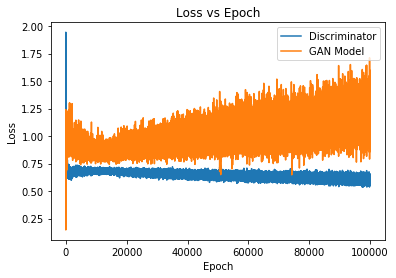

In [ ]:
 # Plot model loss vs epoch
plt.title('Loss vs Epoch')
plt.plot(training_meta_data[:,0]) #Plot the discriminator loss
plt.plot(training_meta_data[:,1]) #Plot the gan loss
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'GAN Model'], loc='upper right')
plt.show()

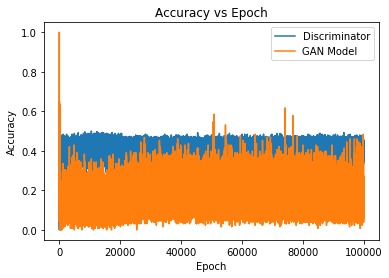

In [ ]:
# Plot accuracy vs epoch
plt.title('Accuracy vs Epoch')
plt.plot(training_meta_data[:,2]) #Plot the discriminator accuracy
plt.plot(training_meta_data[:,3]) #Plot the gan accuracy
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'GAN Model'], loc='upper right')
plt.show()

[4]. Compare and comment on the results of GAN with dropout and without dropout.

ANSWER - After adding dropout we observe GAN loss getting more stable and the accuracy being close to 50% as well. Whereas without the dropout the accuracy decreased to below 20%


[5][a]. Comment on importance of hyper-parameter tuning
Stabilizing GANs are difficult specially due to use of tanh which show great gradient descent properties in a close range. Also stabilizing is tricky due tovanishing gradients in GAN model, hence hyper-parameter tuning is a crucial step. GAN otherwise have risk of non-convergence and model collapsing.

[b] BONUS - Decreasing the learning rate (as shown in the example model below) and also reducing the beta_2 parameter for adam optimizer slightly from 0.999 to 0.9 stabilized GAN even further. We can see the more converging loss and higher GAN accuracy in the below model graphs.


[6]. Answer the following questions:



1.   Why does the accuracy of the discriminator remain around 50%? Is this a good trait of the GAN? 

  ANS: While training the discriminator we are presenting it with 50% real data and 50% fake data. Discriminator reconizes this and converges to the following two scenarios where it classifies real image as fake and fake image as real. For GAN to converge it reaches to an equilibrium state where neither Generator nor Discriminator improves further.


2.   How could this model be modified to produce cleaner (less noisy) images? 

  ANS: Using Deep Convolutional GAN can help learn higher resolution features and help denoising and debluring. 
  Additionally, for further tuning the model, using random seeds for model initialization can impact the performance of GAN due to its nature of hard to stabilize.

11501568/11490434 [==============================] - 1s 0us/step
Epoch 10000
10000: [Discriminaotr loss: 0.633456, acc: 0.382812]  [GAN loss: 1.181916, acc: 0.187500]


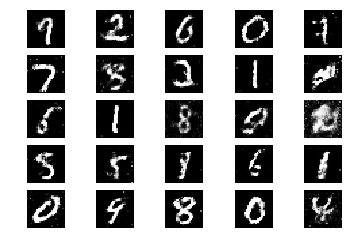

Epoch 20000
20000: [Discriminaotr loss: 0.643656, acc: 0.402344]  [GAN loss: 1.018685, acc: 0.179688]


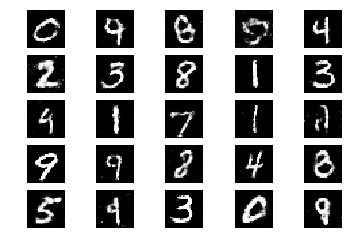

Epoch 30000
30000: [Discriminaotr loss: 0.613005, acc: 0.402344]  [GAN loss: 0.972432, acc: 0.312500]


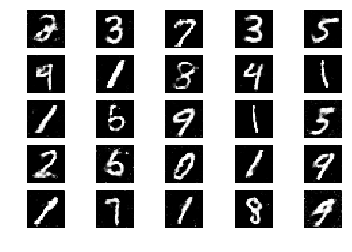

Epoch 40000
40000: [Discriminaotr loss: 0.633331, acc: 0.386719]  [GAN loss: 1.013729, acc: 0.265625]


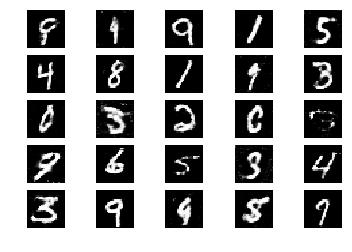

Epoch 50000
50000: [Discriminaotr loss: 0.627889, acc: 0.414062]  [GAN loss: 1.037098, acc: 0.164062]


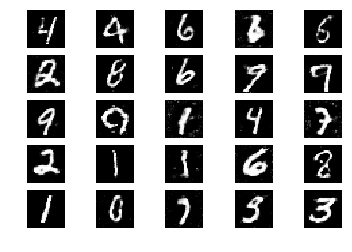

Epoch 60000
60000: [Discriminaotr loss: 0.617366, acc: 0.398438]  [GAN loss: 1.083143, acc: 0.195312]


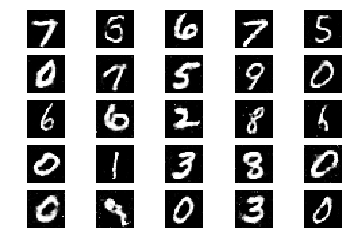

Epoch 70000
70000: [Discriminaotr loss: 0.631772, acc: 0.375000]  [GAN loss: 1.143736, acc: 0.125000]


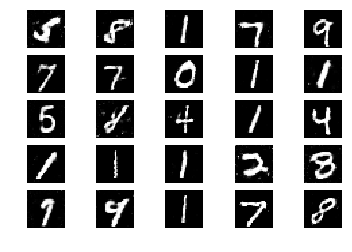

Epoch 80000
80000: [Discriminaotr loss: 0.589502, acc: 0.460938]  [GAN loss: 1.126595, acc: 0.187500]


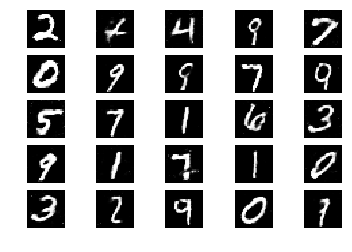

Epoch 90000
90000: [Discriminaotr loss: 0.636478, acc: 0.320312]  [GAN loss: 1.210155, acc: 0.164062]


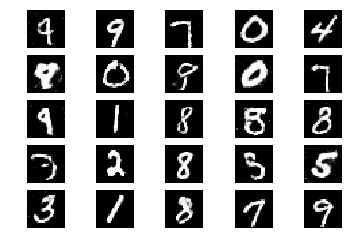

Epoch 100000
100000: [Discriminaotr loss: 0.549745, acc: 0.449219]  [GAN loss: 1.134493, acc: 0.156250]


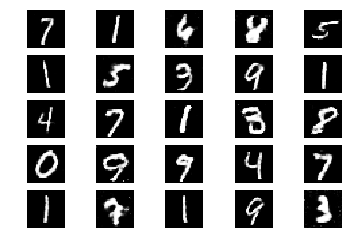

In [2]:
#Load MNIST data and normalize to [-1, 1]
(data_train, labels_train), (data_test, labels_test)= mnist.load_data()
data_train = data_train.reshape(-1, 784)
mean = data_train.mean()
data_train = (data_train - 127.5)/127.5

# The D-dimensional noise vector length
latent_dim = 100

# data_dim
data_dim = 784

# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def adam_optimizer(learning_rate, beta_1, beta_2):
    return adam(learning_rate=learning_rate, beta_1=beta_1, beta_2 = beta_2)

# Genrerator model
def create_generator():
    generator = Sequential()
    generator.add(Dense(300, input_dim=latent_dim))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(600))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(1200))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(data_dim, activation='tanh'))
    return generator

# Discriminator model
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(1200, input_dim=data_dim))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.23))
    discriminator.add(Dense(600))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.23))
    discriminator.add(Dense(300))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.23))
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=adam_optimizer(0.0002, 0.5, 0.9),
                          metrics=['accuracy'])
    return discriminator

# Create adversarial model
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy',
                optimizer=adam_optimizer(0.0002, 0.5, 0.9),
                metrics=['accuracy'])
    return gan

# Creating GAN
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

# Model and training parameters
#ASSIGN VALUES TO THE FOLLOWING VARIABLES
epochs = 100000
batch_size = 128
sample_interval = 10000

# Array to save training history
training_meta_data = np.zeros([epochs, 4])

# Training the GAN
for e in range(1, epochs+1):
    # Generate random noise as input
    random_noise = np.random.normal(0, 1, size=[batch_size, latent_dim])

    # Generate fake MNIST images from generated noise
    fake_images = generator.predict(random_noise)

    # Get a random set of real MNIST images
    real_images = np.array([data_train[np.random.randint(len(data_train))] for i in range(batch_size)])

    # Concatenate real and fake images into a single array (or batch)
    data_total = np.concatenate((fake_images, real_images))

    # Assign training labels (assign high probability, but not 1, to real images)
    labels_fake = np.zeros(batch_size)
    labels_real = np.array([0.9 for i in range(batch_size)])
    labels_total = np.concatenate((labels_fake, labels_real))

    # Allow discriminator parameters to be updated
    discriminator.trainable = True

    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    d_loss = discriminator.train_on_batch(data_total, labels_total)

    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    random_noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    labels_generator = np.ones(batch_size)

    # Keep discriminator weights constant while training generator
    discriminator.trainable = False

    # Train GAN (without updating discriminator weights) on new batch of fake images. Assign loss and accuracy to variable
    gan_loss = gan.train_on_batch(random_noise, labels_generator)

    # Save training status
    # Discriminator and model loss
    training_meta_data[e-1, 0] = d_loss[0]
    training_meta_data[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data[e-1, 2] = d_loss[1]
    training_meta_data[e-1, 3] = gan_loss[1]


    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
        print("Epoch %d" %e)
        log_mesg = "%d: [Discriminaotr loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator.predict(random_noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

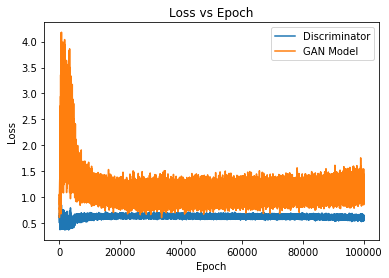

In [3]:
 # Plot model loss vs epoch
plt.title('Loss vs Epoch')
plt.plot(training_meta_data[:,0]) #Plot the discriminator loss
plt.plot(training_meta_data[:,1]) #Plot the gan loss
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'GAN Model'], loc='upper right')
plt.show()

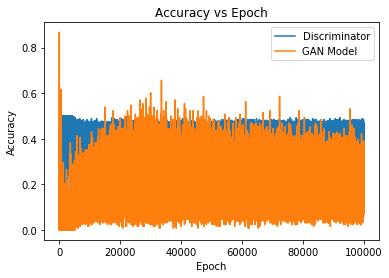

In [4]:
# Plot accuracy vs epoch
plt.title('Accuracy vs Epoch')
plt.plot(training_meta_data[:,2]) #Plot the discriminator accuracy
plt.plot(training_meta_data[:,3]) #Plot the gan accuracy
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'GAN Model'], loc='upper right')
plt.show()

#Part 2: Generating samples using trained generator

In [19]:
# Generate ten images from Gaussian noise using the trained generator from Part 1
gaussian_noise = np.random.normal(0, 1, size=[10, latent_dim])
generated_images = generator.predict(gaussian_noise)

# Re-scale generated images to lie in [0, 1]
generated_images = ((generated_images*127.5)+127.5)/255

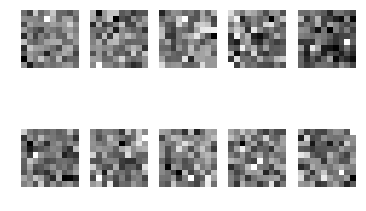

In [20]:
# Visualize generated noise
r, c = 2, 5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((gaussian_noise[cnt].reshape(10, 10)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

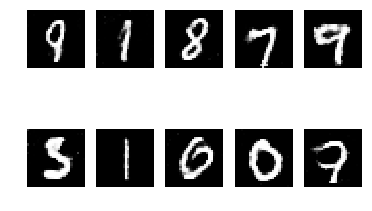

In [21]:
# Visualize generated samples
r, c = 2, 5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((generated_images[cnt].reshape(28, 28)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

#Part 3: Testing accuracy of generated images on ten samples

In [17]:
# Load mnist classifier and generated images
mnist_classifier = load_model('mnist_classifier.h5')

In [27]:
# ASSIGN CLASSES
labels = [9, 1, 8, 7, 9, 3, 1, 0, 0, 7]

# Convert integer labels to one-hot labels 
labels = keras.utils.np_utils.to_categorical(labels, num_classes=10)

# Show classifications
classifications = mnist_classifier.predict(generated_images)

# Evaluate accuracy
correct_classifications = np.count_nonzero(labels.argmax(axis=1)==classifications.argmax(axis=1))
print("Classifier accuracy: %d%%" %(correct_classifications*10))

Classifier accuracy: 100%
